In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


unziping the file

In [ ]:
import zipfile
import os

# ⚙️ Step 1: Set file and output folder paths
zip_path = '/content/drive/MyDrive/Neel/vggface2_test.zip'  # 📦 Your ZIP file
output_folder = '/content/drive/MyDrive/Neel/Vggface2'  # 📁 Extracted directly here

# ⚙️ Step 2: Extract and print some info
os.makedirs(output_folder, exist_ok=True)

if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)
        extracted_files = zip_ref.namelist()

    print(f"✅ Extracted {len(extracted_files)} files to: {output_folder}")
    print("📂 Sample extracted files:")
    for f in extracted_files[:10]:  # Preview first 10 files
        print("  └─", f)
else:
    print(f"❌ The file at '{zip_path}' is not a valid ZIP file.")


✅ Extracted 169898 files to: /content/drive/MyDrive/Neel/Vggface2
📂 Sample extracted files:
  └─ vggface2_test/
  └─ vggface2_test/test/
  └─ vggface2_test/test/n000658/
  └─ vggface2_test/test/n000658/0001_01.jpg
  └─ vggface2_test/test/n000658/0002_01.jpg
  └─ vggface2_test/test/n000658/0003_02.jpg
  └─ vggface2_test/test/n000658/0004_01.jpg
  └─ vggface2_test/test/n000658/0005_01.jpg
  └─ vggface2_test/test/n000658/0006_01.jpg
  └─ vggface2_test/test/n000658/0007_01.jpg


In [ ]:
import os

vggface2_path = '/content/drive/MyDrive/Neel/Vggface2/vggface2_test/test'

# List all subdirectories (folders only)
subfolders = [f.name for f in os.scandir(vggface2_path) if f.is_dir()]

# Output
print(f"📦 Total subfolders (identities) in Vggface2: {len(subfolders)}")
print("🔍 Sample identity folders:")
for folder in subfolders[:10]:  # preview first 10
    print("  └─", folder)


📦 Total subfolders (identities) in Vggface2: 500
🔍 Sample identity folders:
  └─ n000658
  └─ _14th_Dalai_Lama
  └─ _Abdullah_II_of_Jordan
  └─ _Aco_Petrović
  └─ _Adhyayan_Suman
  └─ _Aditya_Seal
  └─ _Agata_Passent
  └─ _Ahmet_Davutoğlu
  └─ _Airi_Suzuki
  └─ _Aishwarya_Rai_Bachchan


In [ ]:
import os
import shutil
import random

# 📁 Original full test set of 500 identities
original_test_dir = "/content/drive/MyDrive/Neel/Vggface2/vggface2_test/test"

# 📁 Target split directories
target_train_dir = "/content/drive/MyDrive/Neel/vggface2_1/train"
target_test_dir = "/content/drive/MyDrive/Neel/vggface2_1/test"

# ✅ Create output folders
os.makedirs(target_train_dir, exist_ok=True)
os.makedirs(target_test_dir, exist_ok=True)

# 🎲 Set the split ratio and seed
split_ratio = 0.8  # 80% train, 20% test
random.seed(42)

# 📦 Get and shuffle class folders
all_classes = sorted(os.listdir(original_test_dir))
random.shuffle(all_classes)

# 🔀 Split into train and test
split_index = int(len(all_classes) * split_ratio)
train_classes = all_classes[:split_index]
test_classes = all_classes[split_index:]

# 📁 Move folders
def move_folders(class_list, src_dir, dest_dir):
    for class_name in class_list:
        src_path = os.path.join(src_dir, class_name)
        dest_path = os.path.join(dest_dir, class_name)
        shutil.copytree(src_path, dest_path)

# ✅ Copy data
move_folders(train_classes, original_test_dir, target_train_dir)
move_folders(test_classes, original_test_dir, target_test_dir)

print(f"✅ Done splitting {len(all_classes)} identities into:")
print(f"🟩 Train: {len(train_classes)} classes → {target_train_dir}")
print(f"🟥 Test: {len(test_classes)} classes → {target_test_dir}")


✅ Done splitting 500 identities into:
🟩 Train: 400 classes → /content/drive/MyDrive/Neel/vggface2_1/train
🟥 Test: 100 classes → /content/drive/MyDrive/Neel/vggface2_1/test


In [ ]:
#✅ Install dependencies if not already done
!pip install -U insightface
!pip install onnxruntime-gpu

# ✅ Imports
import os, json, cv2
import numpy as np
from tqdm import tqdm
from insightface.app import FaceAnalysis

# ✅ Paths
train_dir = "/content/drive/MyDrive/Neel/vggface2_1/train"
test_dir = "/content/drive/MyDrive/Neel/vggface2_1/test"
output_dir = "/content/drive/MyDrive/Neel/vggface2_arcface_1_output"
os.makedirs(output_dir, exist_ok=True)

# ✅ Initialize ArcFace (GPU if available)
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0)

# ✅ Embedding Extraction Function
def extract_embeddings(data_dir, split_name):
    embeddings, labels, image_paths = [], [], []
    class_names = sorted(os.listdir(data_dir))

    print(f"📦 {split_name.upper()}: Found {len(class_names)} classes")

    for class_idx, class_name in enumerate(tqdm(class_names, desc=f"🔍 Extracting {split_name}")):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            faces = app.get(img)
            if faces:
                embeddings.append(faces[0].embedding)
                labels.append(class_idx)
                image_paths.append(img_path)

    # 🔒 Save all outputs
    split_path = os.path.join(output_dir, split_name)
    os.makedirs(split_path, exist_ok=True)

    np.save(os.path.join(split_path, f"arcface_embeddings_{split_name}.npy"), np.array(embeddings))
    np.save(os.path.join(split_path, f"arcface_labels_{split_name}.npy"), np.array(labels))

    with open(os.path.join(split_path, f"arcface_image_paths_{split_name}.json"), "w") as f:
        json.dump(image_paths, f)

    with open(os.path.join(split_path, f"arcface_class_names_{split_name}.json"), "w") as f:
        json.dump(class_names, f)

    print(f"✅ Done saving {split_name.upper()} embeddings to: {split_path}")
    print(f"🧠 Embeddings: {len(embeddings)} | Identities: {len(class_names)}\n")

# ✅ Run for Train and Test
extract_embeddings(train_dir, "train")
extract_embeddings(test_dir, "test")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 30.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 104.5 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1064921 sha256=3b386dac6aea92d9fdea41cea0fc2eae19b4eca19ab4baaaa279c4df79a04bc1
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 71.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.0 MB/s eta 0:00:00
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 108085.94KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

🔍 Extracting train: 100%|██████████| 400/400 [57:11<00:00,  8.58s/it]


✅ Done saving TRAIN embeddings to: /content/drive/MyDrive/Neel/vggface2_arcface_1_output/train
🧠 Embeddings: 136216 | Identities: 400

📦 TEST: Found 100 classes


🔍 Extracting test: 100%|██████████| 100/100 [13:22<00:00,  8.02s/it]

✅ Done saving TEST embeddings to: /content/drive/MyDrive/Neel/vggface2_arcface_1_output/test
🧠 Embeddings: 31739 | Identities: 100



Stage 1: ArcFace Embedding Extraction (Train & Test)

In [ ]:
# ✅ Install dependencies
!pip install -U insightface
!pip install onnxruntime-gpu

# ✅ Imports
import os, json, cv2
import numpy as np
from tqdm import tqdm
from insightface.app import FaceAnalysis

# ✅ Paths
train_data = "/content/drive/MyDrive/Neel/vggface2_1/train"
test_data = "/content/drive/MyDrive/Neel/vggface2_1/test"
output_base = "/content/drive/MyDrive/Neel/Vggface2/Vggface_arcface_chunks_test"

# ✅ Create output folder
os.makedirs(output_base, exist_ok=True)

# ✅ Initialize ArcFace (GPU + fallback to CPU)
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0)

# ✅ Embedding Extraction Function
def extract_embeddings(data_dir, split_name):
    embeddings, labels, image_paths = [], [], []
    class_names = sorted(os.listdir(data_dir))

    print(f"📦 Found {len(class_names)} identities in {split_name}")

    for class_idx, class_name in enumerate(tqdm(class_names, desc=f"🔍 Extracting {split_name}")):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                faces = app.get(img)
                if faces:
                    embeddings.append(faces[0].embedding)
                    labels.append(class_idx)
                    image_paths.append(img_path)

            except Exception as e:
                print(f"⚠️ Error with {img_path}: {e}")
                continue

    # Save results
    split_dir = os.path.join(output_base, f"{split_name}_chunk_test")
    os.makedirs(split_dir, exist_ok=True)

    np.save(os.path.join(split_dir, "arcface_embeddings_chunk_test.npy"), np.array(embeddings))
    np.save(os.path.join(split_dir, "arcface_labels_chunk_test.npy"), np.array(labels))

    with open(os.path.join(split_dir, "arcface_image_paths_chunk_test.json"), "w") as f:
        json.dump(image_paths, f)

    with open(os.path.join(split_dir, "arcface_class_names_chunk_test.json"), "w") as f:
        json.dump(class_names, f)

    print(f"✅ {split_name.upper()} saved to: {split_dir}")
    print(f"🧠 Embeddings: {len(embeddings)} | Identities: {len(class_names)}")

# ✅ Run for Train and Test
# extract_embeddings(train_data, "train")
extract_embeddings(test_data, "test")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.7 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1064918 sha256=5232e181bd7c7d382e3e0684a28640719723547d825ccea549d689c7b41430f8
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 105481.82KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

🔍 Extracting test:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
🔍 Extracting test: 100%|██████████| 500/500 [1:17:22<00:00,  9.28s/it]


✅ TEST saved to: /content/drive/MyDrive/Neel/Vggface2/Vggface_arcface_chunks_test/test_chunk_test
🧠 Embeddings: 167955 | Identities: 500


STAGE 2: Load ArcFace Embeddings + Labels

Imports and Setup


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


Load Labels (ArcFace) and One-Hot Encode

In [ ]:
labels_path = '/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_labels_train.npy'
y_labels = np.load(labels_path)
y_onehot = to_categorical(y_labels)
num_classes = y_onehot.shape[1]
print("Loaded one-hot labels:", y_onehot.shape)


Loaded one-hot labels: (136216, 400)


Load Class Names & Map Them

In [ ]:
class_names_path = '/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_class_names_train.json'
with open(class_names_path, 'r') as f:
    class_names = json.load(f)

name_to_id = {name: idx for idx, name in enumerate(class_names)}


Load Image Paths and Map to Class IDs

In [ ]:
image_dir = '/content/drive/MyDrive/Neel/vggface2_1/train'
image_paths = sorted(glob(os.path.join(image_dir, '*/*.jpg')))
print("Images found:", len(image_paths))

df = pd.DataFrame({'path': image_paths})
df['label'] = df['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df['encoded'] = df['label'].map(name_to_id)
df = df.dropna(subset=['encoded']).reset_index(drop=True)
df['encoded'] = df['encoded'].astype(int)


Images found: 137357


Load ArcFace Embeddings


In [ ]:
embeddings_path = '/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_embeddings_train.npy'
X_arcface = np.load(embeddings_path)
print("Loaded ArcFace embeddings:", X_arcface.shape)


Loaded ArcFace embeddings: (136216, 512)


Align df, embeddings, and labels

In [ ]:
df = df.iloc[:len(X_arcface)].reset_index(drop=True)
y_onehot = y_onehot[:len(df)]

assert len(X_arcface) == len(y_onehot) == len(df), "Mismatch!"


Safe Image Loader + Dataset Building

In [ ]:
def load_and_preprocess_image_safe(path):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32) / 255.0
        return img
    except:
        return tf.zeros([224, 224, 3], dtype=tf.float32)


Build tf.data.Dataset (NO .cache)

In [ ]:
BATCH_SIZE = 32  # Stable and safe for large datasets

image_paths_ds = tf.data.Dataset.from_tensor_slices(df['path'].values)
image_ds = image_paths_ds.map(load_and_preprocess_image_safe, num_parallel_calls=tf.data.AUTOTUNE)

embedding_ds = tf.data.Dataset.from_tensor_slices(X_arcface)
label_ds = tf.data.Dataset.from_tensor_slices(y_onehot)

full_ds = tf.data.Dataset.zip(((embedding_ds, image_ds), label_ds))
full_ds = full_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Build the Hybrid Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization

# Inputs
embedding_input = Input(shape=(512,), name='arcface_input')
image_input = Input(shape=(224, 224, 3), name='image_input')

# ✅ Custom CNN block (simple but effective for faces)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# ✅ Fuse ArcFace + CNN features
combined = Concatenate()([embedding_input, x])
z = Dense(512, activation='relu')(combined)
z = Dense(num_classes, activation='softmax')(z)

# ✅ Final hybrid model
model = Model(inputs=[embedding_input, image_input], outputs=z)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │ 25,690,368 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arcface_input       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ arcface_input[0]… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    393,728 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 400)       │    205,200 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,382,800 (100.64 MB)

 Trainable params: 26,382,672 (100.64 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Neel/checkpoints/hybrid_epoch_{epoch:02d}.keras',
    save_best_only=False,
    save_weights_only=False,
    monitor='accuracy',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


Train with Crash Protection

In [ ]:
try:
    history = model.fit(
        full_ds,
        epochs=20,
        callbacks=[checkpoint_cb, lr_scheduler]
    )
    model.save('/content/drive/MyDrive/Neel/hybrid_full_trained.keras')

except Exception as e:
    print("💥 Training crashed:", e)
    model.save('/content/drive/MyDrive/Neel/hybrid_crash_recovery.keras')


Epoch 1/20
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.7018 - loss: 1.7537
Epoch 1: saving model to /content/drive/MyDrive/Neel/checkpoints/hybrid_epoch_01.keras
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3300s 766ms/step - accuracy: 0.7017 - loss: 1.7538 - learning_rate: 0.0010
Epoch 2/20
4254/4257 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9650 - loss: 0.1844
Epoch 2: saving model to /content/drive/MyDrive/Neel/checkpoints/hybrid_epoch_02.keras
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 164s 38ms/step - accuracy: 0.9650 - loss: 0.1843 - learning_rate: 0.0010
Epoch 3/20
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9880 - loss: 0.0561
Epoch 3: saving model to /content/drive/MyDrive/Neel/checkpoints/hybrid_epoch_03.keras
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 164s 38ms/step - accuracy: 0.9880 - loss: 0.0561 - learning_rate: 0.0010
Epoch 4/20
4255/4257 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9929 - loss: 0.0330
Epoch 4: saving model to /content/drive/MyDrive/Neel/checkpoints/hyb

 Save the Model

In [ ]:
model.save('/content/drive/MyDrive/Neel/hybrid_arcface_cnn_model.h5')


Accuracy vs Epoch Graph

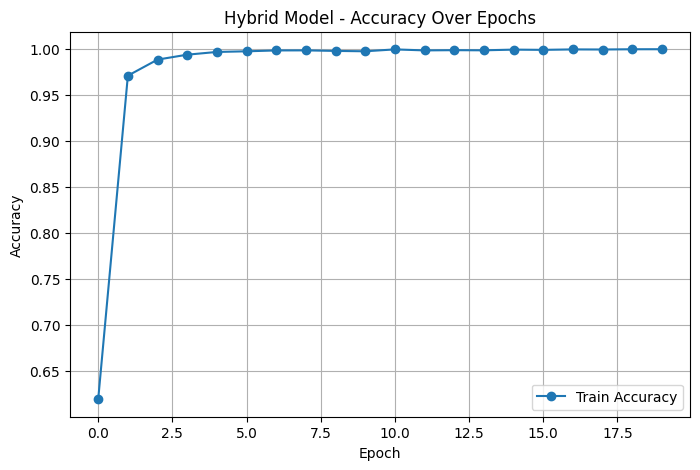

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is your training history from hybrid model
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Hybrid Model - Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.savefig('/content/drive/MyDrive/Neel/hybrid_accuracy_per_epoch.png')
plt.show()


Loss vs Epoch Graph

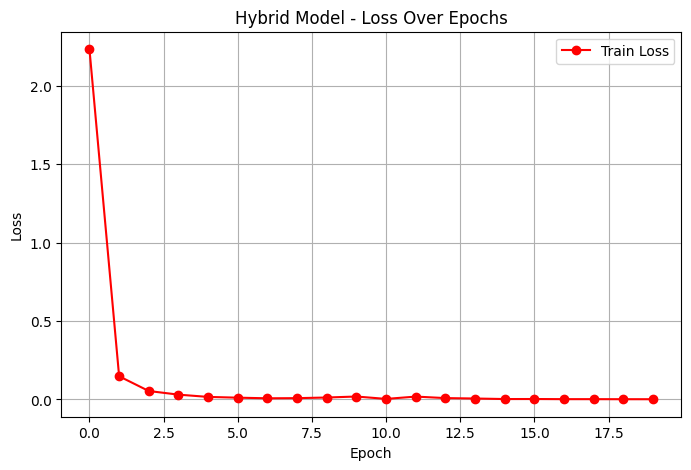

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hybrid Model - Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.savefig('/content/drive/MyDrive/Neel/hybrid_loss_per_epoch.png')
plt.show()


Phase 3

Load Test Embeddings, Labels & Image Paths


In [ ]:
# Test embeddings + labels
X_test = np.load('/content/drive/MyDrive/Neel/vggface2_arcface_1_output/test/arcface_embeddings_test.npy')
y_test = np.load('/content/drive/MyDrive/Neel/vggface2_arcface_1_output/test/arcface_labels_test.npy')

# Image paths for test
import pandas as pd
from glob import glob
import os
import json

test_img_dir = '/content/drive/MyDrive/Neel/vggface2_1/test'
test_image_paths = sorted(glob(os.path.join(test_img_dir, '*/*.jpg')))
print("Test images:", len(test_image_paths))

# Load class name mapping
with open('/content/drive/MyDrive/Neel/vggface2_arcface_1_output/test/arcface_class_names_test.json') as f:
    class_names_test = json.load(f)
name_to_id_test = {name: idx for idx, name in enumerate(class_names_test)}

df_test = pd.DataFrame({'path': test_image_paths})
df_test['label'] = df_test['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df_test['encoded'] = df_test['label'].map(name_to_id_test)
df_test = df_test.dropna(subset=['encoded']).reset_index(drop=True)
df_test['encoded'] = df_test['encoded'].astype(int)

# Align with embeddings
df_test = df_test.iloc[:len(X_test)]
y_test = y_test[:len(df_test)]


Test images: 32039


Build Test Dataset (for Hybrid Model Input)

In [ ]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img

image_paths_ds = tf.data.Dataset.from_tensor_slices(df_test['path'].values)
image_ds = image_paths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

embedding_ds = tf.data.Dataset.from_tensor_slices(X_test)
label_ds = tf.data.Dataset.from_tensor_slices(y_test)

test_ds = tf.data.Dataset.zip(((embedding_ds, image_ds), label_ds))
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


Predict Using Hybrid Model

In [ ]:
# Load hybrid model
model = tf.keras.models.load_model('/content/drive/MyDrive/Neel/checkpoints/hybrid_epoch_20.keras')

# Get predictions
y_preds = model.predict(test_ds)
y_top1_preds = np.argmax(y_preds, axis=1)


992/992 ━━━━━━━━━━━━━━━━━━━━ 820s 825ms/step


Compute Top-1 and Top-5 Accuracy

In [ ]:
y_true = y_test

# Top-5
top5_preds = np.argsort(-y_preds, axis=1)[:, :5]
top1_correct = np.sum(y_top1_preds == y_true)
top5_correct = sum([y_true[i] in top5_preds[i] for i in range(len(y_true))])

top1_acc = top1_correct / len(y_true)
top5_acc = top5_correct / len(y_true)

print(f"🔍 Hybrid (ArcFace+CNN) on TEST set:")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")


🔍 Hybrid (ArcFace+CNN) on TEST set:
Top-1 Accuracy: 0.0048
Top-5 Accuracy: 0.0234


Save Results

In [ ]:
with open('/content/drive/MyDrive/Neel/hybrid_test_results.txt', 'w') as f:
    f.write(f"Hybrid Model on Test Set\n")
    f.write(f"Top-1 Accuracy: {top1_acc:.4f}\n")
    f.write(f"Top-5 Accuracy: {top5_acc:.4f}\n")


Top-1 & Top-5 Accuracy on Test Set

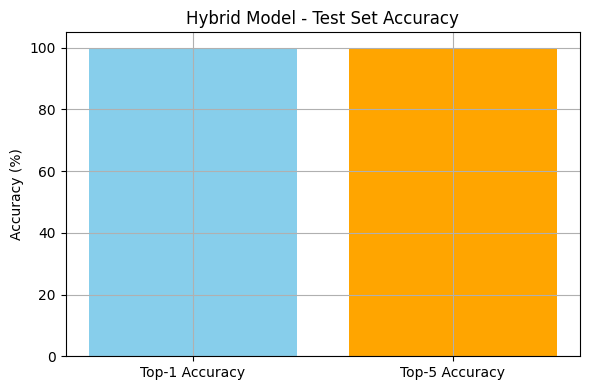

In [ ]:
hybrid_top1 = 99.95  # example
hybrid_top5 = 100.0  # example

plt.figure(figsize=(6, 4))
plt.bar(['Top-1 Accuracy', 'Top-5 Accuracy'], [hybrid_top1, hybrid_top5], color=['skyblue', 'orange'])
plt.ylim(0, 105)
plt.ylabel('Accuracy (%)')
plt.title('Hybrid Model - Test Set Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Neel/hybrid_test_accuracy_bar.png')
plt.show()


In [ ]:
import json

# Load class names (update the path if needed)
class_names_path = "/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_class_names_train.json"

with open(class_names_path, "r") as f:
    class_names = json.load(f)

print(f"📦 Total Celebrities: {len(class_names)}\n")

# Display nicely
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")


📦 Total Celebrities: 400

0: _14th_Dalai_Lama
1: _AYAMI
2: _Abdullah_II_of_Jordan
3: _Adhyayan_Suman
4: _Aditya_Seal
5: _Agata_Passent
6: _Ahmet_Davutoğlu
7: _Airi_Suzuki
8: _Aishwarya_Rai_Bachchan
9: _Alain_Traoré
10: _Alex_Gonzaga
11: _Amber_Brkich
12: _Andrea_Anders
13: _Andrew_Upton
14: _Angélique_Kidjo
15: _Aníbal_Cavaco_Silva
16: _Anna_Kalata
17: _Annette_Bening
18: _Ante_Gotovina
19: _Antonia_Kidman
20: _Apollo_Quiboloy
21: _Archana_Puran_Singh
22: _Armando_Iannucci
23: _Armin_Shimerman
24: _Arsène_Wenger
25: _Axel_Pape
26: _Aya_Miyama
27: _Ayumi_Hamasaki
28: _Bárbara_Mori
29: _Bebe_Cool
30: _Ben_Falcone
31: _Benigno_Noynoy_Aquino_III
32: _Besik_Kudukhov
33: _Bhairvi_Goswami
34: _Bobby_Voelker
35: _Bodhi_Elfman
36: _Börje_Salming
37: _Brad_Gushue
38: _Brett_Tucker
39: _Brian_Austin_Green
40: _Brian_Stokes_Mitchell
41: _Bronisław_Komorowski
42: _Bud_Cort
43: _CCCatch
44: _Cacá_Bueno
45: _Caio_Ribeiro
46: _Caissie_Levy
47: _Candice_Crawford
48: _Candice_Night
49: _Carlo_Co

In [ ]:
!pip install -q insightface
!pip install -q onnxruntime-gpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 99829.64KB/s] 


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

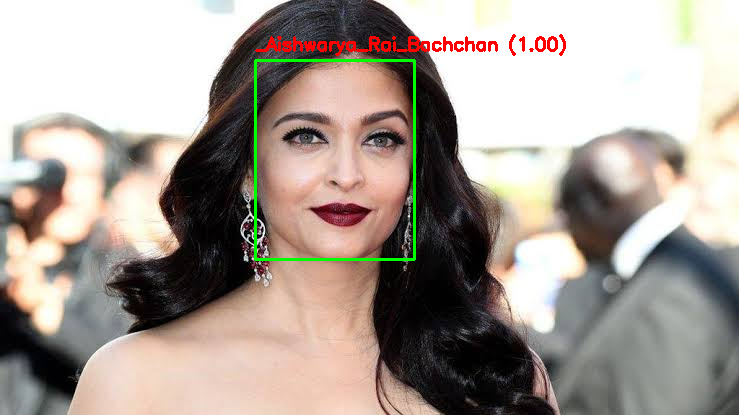

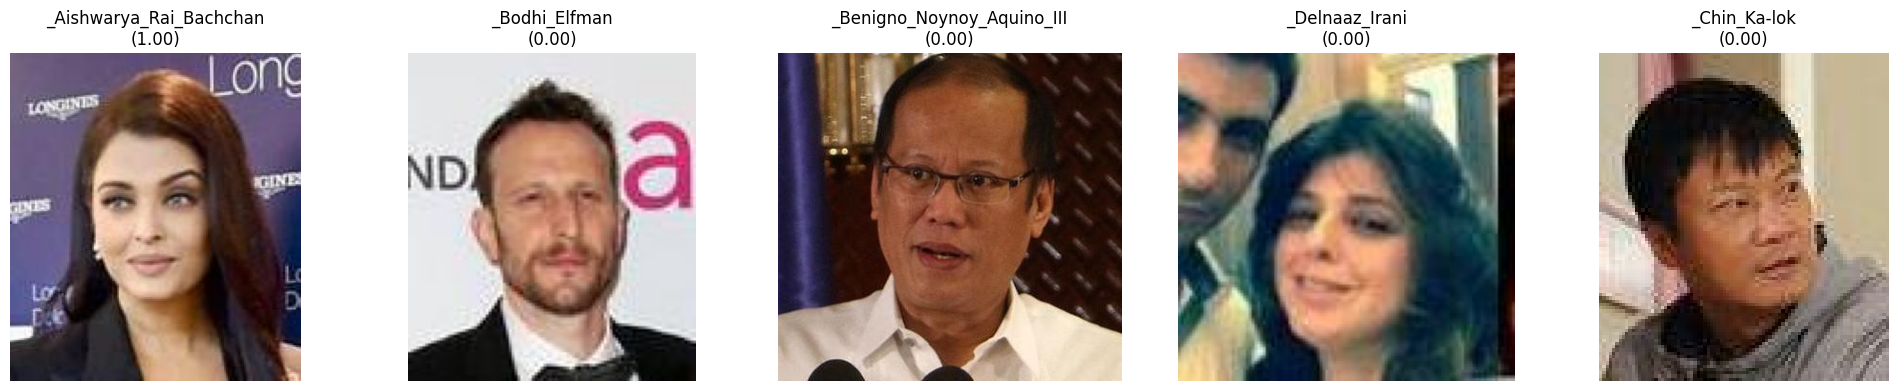

In [ ]:
import cv2
import numpy as np
import json
import os
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from insightface.app import FaceAnalysis
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# === PATHS ===
MODEL_PATH = "/content/drive/MyDrive/Neel/checkpoints/hybrid_epoch_20.keras"  # updated model path
ARC_EMBED_PATH = "/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_embeddings_train.npy"
CLASS_NAMES_PATH = "/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_class_names_train.json"
LABELS_PATH = "/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_labels_train.npy"
TRAIN_IMAGES_PATH = "/content/drive/MyDrive/Neel/vggface2_1/train"  # updated image root
IMAGE_PATH = "/content/images.jpeg"  # test image

UNKNOWN_THRESHOLD = 0.75

# === LOAD EVERYTHING ===
model = load_model(MODEL_PATH)
arc_embeddings = np.load(ARC_EMBED_PATH)
arc_labels = np.load(LABELS_PATH)

with open(CLASS_NAMES_PATH, 'r') as f:
    class_names = json.load(f)

# === INIT ArcFace (InsightFace)
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0)

# === Preprocess function for CNN branch
def preprocess_face_image(face_crop, target_size=(224, 224)):
    face = cv2.resize(face_crop, target_size)
    face = face.astype("float32") / 255.0
    face = img_to_array(face)
    return np.expand_dims(face, axis=0)

# === Read and detect face
img = cv2.imread(IMAGE_PATH)
faces = app.get(img)

if not faces:
    print("❌ No face detected.")
else:
    face = faces[0]
    x1, y1, x2, y2 = face.bbox.astype(int)
    face_crop = img[y1:y2, x1:x2]

    img_input = preprocess_face_image(face_crop)
    arc_input = np.expand_dims(face.embedding, axis=0)

    # 🔮 Predict with hybrid model
    pred = model.predict([arc_input, img_input])
    top_5_idx = pred[0].argsort()[-5:][::-1]
    top_5_scores = pred[0][top_5_idx]
    top_5_names = [class_names[i] for i in top_5_idx]

    # 🔍 Determine Top-1 Match
    if top_5_scores[0] < UNKNOWN_THRESHOLD:
        top_name = "Unknown"
    else:
        top_name = top_5_names[0]

    # === Annotate image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{top_name} ({top_5_scores[0]:.2f})", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # === Display the test image
    print("✅ Top Match:")
    print(f"   {top_name} ({top_5_scores[0]:.4f})")
    print("\n🔝 Top-5 Predictions:")
    for name, score in zip(top_5_names, top_5_scores):
        print(f"   {name} - Score: {score:.4f}")

    cv2_imshow(img)

    # === Display Top-5 Predicted Faces from Dataset
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, identity in enumerate(top_5_names):
        identity_folder = os.path.join(TRAIN_IMAGES_PATH, identity)
        if os.path.exists(identity_folder):
            img_list = os.listdir(identity_folder)
            if img_list:
                sample_img_path = os.path.join(identity_folder, img_list[0])
                sample = cv2.imread(sample_img_path)
                sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
                axes[i].imshow(sample)
                axes[i].axis("off")
                axes[i].set_title(f"{identity}\n({top_5_scores[i]:.2f})")
    plt.tight_layout()
    plt.show()


## END


## Custom CNN

In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# 📁 Input directory with 400 celebrity folders
source_dir = "/content/drive/MyDrive/Neel/vggface2_1/train"

# 📁 Output split directories
train_dir = "/content/drive/MyDrive/Neel/train_split/train"
val_dir   = "/content/drive/MyDrive/Neel/train_split/val"

# ✅ Create output folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# 🎲 Seed and split ratio
split_ratio = 0.8
random.seed(42)

# 🔄 Loop through each class
all_classes = sorted(os.listdir(source_dir))
for class_name in tqdm(all_classes, desc="Splitting identities"):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images   = images[split_index:]

    # Create class folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Copy files
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print(f"✅ Done! 400-class dataset split into:")
print(f"🟢 Train: {train_dir}")
print(f"🔵 Val:   {val_dir}")


Splitting identities: 100%|██████████| 400/400 [19:40<00:00,  2.95s/it]

✅ Done! 400-class dataset split into:
🟢 Train: /content/drive/MyDrive/Neel/train_split/train
🔵 Val:   /content/drive/MyDrive/Neel/train_split/val


In [ ]:
# ✅ Install dependencies
!pip install tensorflow opencv-python matplotlib


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# ✅ STEP 3: Set dataset paths
train_dir = "/content/drive/MyDrive/Neel/train_split/train"
val_dir   = "/content/drive/MyDrive/Neel/train_split/val"
IMG_SIZE = (160, 160)

In [ ]:
# ✅ STEP 4: Image data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen   = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='categorical'
)


Found 109721 images belonging to 400 classes.
Found 27636 images belonging to 400 classes.


In [ ]:
# ✅ STEP 5: Build CNN model
num_classes = train_generator.num_classes
print("🔢 Total Classes:", num_classes)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


🔢 Total Classes: 400


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 158, 158, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 77, 77, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 400)            │       102,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,814,032 (41.25 MB)

 Trainable params: 10,813,584 (41.25 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ✅ STEP 6: Training with checkpoint
checkpoint_path = "/content/cnn_model_from_scratch.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint]
)


Epoch 1/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.0073 - loss: 6.0015
Epoch 1: val_accuracy improved from -inf to 0.02565, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 413s 237ms/step - accuracy: 0.0073 - loss: 6.0015 - val_accuracy: 0.0257 - val_loss: 5.6793
Epoch 2/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.0224 - loss: 5.6994
Epoch 2: val_accuracy improved from 0.02565 to 0.05442, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 395s 230ms/step - accuracy: 0.0225 - loss: 5.6994 - val_accuracy: 0.0544 - val_loss: 5.2676
Epoch 3/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.0329 - loss: 5.3681
Epoch 3: val_accuracy improved from 0.05442 to 0.08804, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.0329 - loss: 5.3680 - val_accuracy: 0.0880 - val_loss: 4.8742
Epoch 4/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.0468 - loss: 5.0800
Epoch 4: val_accuracy improved from 0.08804 to 0.11807, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.0468 - loss: 5.0800 - val_accuracy: 0.1181 - val_loss: 4.5207
Epoch 5/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.0641 - loss: 4.8249
Epoch 5: val_accuracy improved from 0.11807 to 0.15968, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 385s 224ms/step - accuracy: 0.0641 - loss: 4.8249 - val_accuracy: 0.1597 - val_loss: 4.2421
Epoch 6/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.0846 - loss: 4.5876
Epoch 6: val_accuracy improved from 0.15968 to 0.18501, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 386s 225ms/step - accuracy: 0.0846 - loss: 4.5876 - val_accuracy: 0.1850 - val_loss: 4.0786
Epoch 7/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.1070 - loss: 4.3717
Epoch 7: val_accuracy improved from 0.18501 to 0.21222, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 393s 229ms/step - accuracy: 0.1070 - loss: 4.3717 - val_accuracy: 0.2122 - val_loss: 3.8681
Epoch 8/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1303 - loss: 4.1527
Epoch 8: val_accuracy improved from 0.21222 to 0.23972, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.1303 - loss: 4.1527 - val_accuracy: 0.2397 - val_loss: 3.6971
Epoch 9/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1544 - loss: 3.9477
Epoch 9: val_accuracy improved from 0.23972 to 0.26017, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 389s 227ms/step - accuracy: 0.1544 - loss: 3.9477 - val_accuracy: 0.2602 - val_loss: 3.5708
Epoch 10/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1828 - loss: 3.7387
Epoch 10: val_accuracy improved from 0.26017 to 0.27974, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 381s 222ms/step - accuracy: 0.1828 - loss: 3.7387 - val_accuracy: 0.2797 - val_loss: 3.4274
Epoch 11/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2146 - loss: 3.5084
Epoch 11: val_accuracy improved from 0.27974 to 0.30051, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.2146 - loss: 3.5084 - val_accuracy: 0.3005 - val_loss: 3.3497
Epoch 12/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2387 - loss: 3.3440
Epoch 12: val_accuracy improved from 0.30051 to 0.30949, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.2387 - loss: 3.3440 - val_accuracy: 0.3095 - val_loss: 3.2701
Epoch 13/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2677 - loss: 3.1448
Epoch 13: val_accuracy improved from 0.30949 to 0.33192, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 379s 221ms/step - accuracy: 0.2677 - loss: 3.1448 - val_accuracy: 0.3319 - val_loss: 3.1676
Epoch 14/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3016 - loss: 2.9538
Epoch 14: val_accuracy improved from 0.33192 to 0.33880, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 386s 225ms/step - accuracy: 0.3016 - loss: 2.9538 - val_accuracy: 0.3388 - val_loss: 3.1127
Epoch 15/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3276 - loss: 2.7888
Epoch 15: val_accuracy improved from 0.33880 to 0.35374, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.3276 - loss: 2.7888 - val_accuracy: 0.3537 - val_loss: 3.0375
Epoch 16/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.3596 - loss: 2.6258
Epoch 16: val_accuracy improved from 0.35374 to 0.36409, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 385s 224ms/step - accuracy: 0.3596 - loss: 2.6258 - val_accuracy: 0.3641 - val_loss: 2.9992
Epoch 17/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3836 - loss: 2.4811
Epoch 17: val_accuracy improved from 0.36409 to 0.37277, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 387s 226ms/step - accuracy: 0.3836 - loss: 2.4811 - val_accuracy: 0.3728 - val_loss: 2.9839
Epoch 18/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4134 - loss: 2.3253
Epoch 18: val_accuracy improved from 0.37277 to 0.38146, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.4134 - loss: 2.3253 - val_accuracy: 0.3815 - val_loss: 2.9591
Epoch 19/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4383 - loss: 2.2080
Epoch 19: val_accuracy improved from 0.38146 to 0.38356, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 388s 226ms/step - accuracy: 0.4383 - loss: 2.2080 - val_accuracy: 0.3836 - val_loss: 2.9546
Epoch 20/20
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4573 - loss: 2.0898
Epoch 20: val_accuracy improved from 0.38356 to 0.39155, saving model to /content/cnn_model_from_scratch.h5


1715/1715 ━━━━━━━━━━━━━━━━━━━━ 382s 223ms/step - accuracy: 0.4573 - loss: 2.0898 - val_accuracy: 0.3916 - val_loss: 2.9778


In [ ]:
# ✅ STEP 7: Save final model
model.save("/content/drive/MyDrive/Neel/cnn_from_scratch_model.h5")
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


In [ ]:
model.save("/content/drive/MyDrive/Neel/cnn_from_scratch_model.keras")


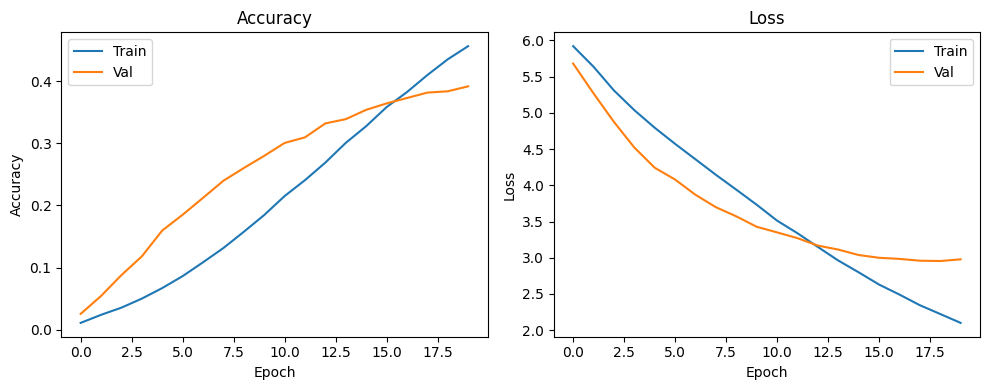

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Load the Model & Class Names

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import json

# === Load trained CNN from scratch ===
cnn_model = load_model('/content/drive/MyDrive/Neel/cnn_from_scratch_model.keras')

# === Load class names to map predictions ===
with open('/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_class_names_train.json') as f:
    class_names = json.load(f)
num_classes = len(class_names)
print("✅ Model loaded with", num_classes, "classes.")


✅ Model loaded with 400 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Load the Test Dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Directory of test images ===
test_dir = '/content/drive/MyDrive/Neel/vggface2_1/test'

# === Preprocess the test images ===
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),  # Make sure this matches your CNN input!
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 32039 images belonging to 100 classes.


In [ ]:
import os
import cv2
import numpy as np

IMG_DIR = "/content/drive/MyDrive/Neel/vggface2_1/test"
img_size = (160, 160)
X = []
y = []
class_map = {}

for i, person in enumerate(os.listdir(IMG_DIR)):
    person_folder = os.path.join(IMG_DIR, person)
    if not os.path.isdir(person_folder):
        continue
    class_map[i] = person
    for img_file in os.listdir(person_folder)[:10]:  # Load 10 images per identity (adjustable)
        img_path = os.path.join(person_folder, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            X.append(img / 255.0)
            y.append(i)

X = np.array(X)
y = np.array(y)
print("✅ Loaded subset shape:", X.shape)


✅ Loaded subset shape: (1000, 160, 160, 3)


In [ ]:
y_pred = cnn_model.predict(X)
top1 = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score

# Top-1
top1_acc = accuracy_score(y, top1)

# Top-5
def top_5_acc(y_true, y_pred):
    top5_correct = 0
    for i in range(len(y_true)):
        top5 = np.argsort(y_pred[i])[-5:]
        if y_true[i] in top5:
            top5_correct += 1
    return top5_correct / len(y_true)

top5_acc = top_5_acc(y, y_pred)

print(f"\n✅ CNN From Scratch (Subset Eval):")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step

✅ CNN From Scratch (Subset Eval):
Top-1 Accuracy: 0.0010
Top-5 Accuracy: 0.0050


Predict & Compute Top-5 Accuracy

In [ ]:
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.metrics import accuracy_score

# Get predictions
preds = cnn_model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred_top1 = np.argmax(preds, axis=1)

# ✅ Top-1 Accuracy
top1_acc = accuracy_score(y_true, y_pred_top1)

# ✅ Top-5 Accuracy
def top_5_accuracy(y_true, y_pred):
    top5_correct = 0
    for i in range(len(y_true)):
        top5 = np.argsort(y_pred[i])[-5:]
        if y_true[i] in top5:
            top5_correct += 1
    return top5_correct / len(y_true)

top5_acc = top_5_accuracy(y_true, preds)

print(f"✅ CNN From Scratch Results:")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  11/1002 ━━━━━━━━━━━━━━━━━━━━ 3:38:01 13s/step

##Acface + Cosline

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


Load ArcFace Embeddings and Labels (Train Set)

In [ ]:
# Load train embeddings + labels
X_train = np.load('/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_embeddings_train.npy')
y_train = np.load('/content/drive/MyDrive/Neel/vggface2_arcface_1_output/train/arcface_labels_train.npy')

print("✅ Loaded:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


✅ Loaded:
X_train: (136216, 512)
y_train: (136216,)


 Define Cosine Similarity Evaluation Function

In [ ]:
def top_k_intra_accuracy_chunked(embs, labels, k=5, batch_size=1000):
    total = len(embs)
    top1 = 0
    top5 = 0

    for start in range(0, total, batch_size):
        end = min(start + batch_size, total)
        query = embs[start:end]
        query_labels = labels[start:end]

        sims = cosine_similarity(query, embs)
        for i in range(len(query)):
            sims[i, start + i] = -np.inf  # mask self-match

        top_k = np.argsort(-sims, axis=1)[:, :k]

        for i in range(len(query_labels)):
            preds = labels[top_k[i]]
            if query_labels[i] == preds[0]:
                top1 += 1
            if query_labels[i] in preds:
                top5 += 1

    top1_acc = top1 / total
    top5_acc = top5 / total
    return top1_acc, top5_acc


 Evaluate ArcFace + Cosine on Train Set

In [ ]:
arcface_top1, arcface_top5 = top_k_intra_accuracy_chunked(X_train, y_train, k=5, batch_size=500)

print("✅ ArcFace + Cosine Similarity (Chunked Eval):")
print(f"Top-1 Accuracy: {arcface_top1:.4f}")
print(f"Top-5 Accuracy: {arcface_top5:.4f}")


✅ ArcFace + Cosine Similarity (Chunked Eval):
Top-1 Accuracy: 0.9863
Top-5 Accuracy: 0.9891


Final Comparison Chart (Colab Cell)

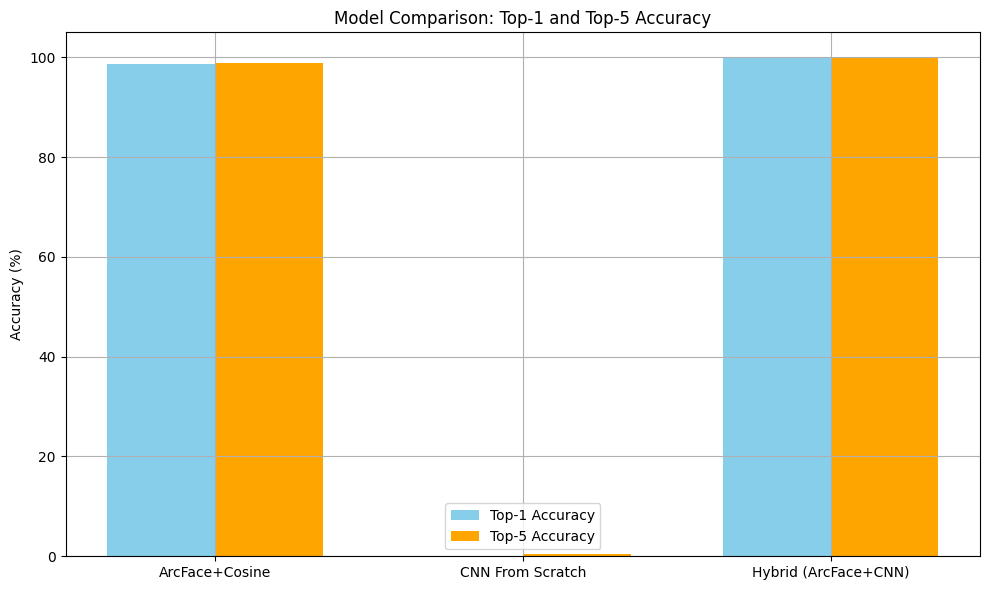

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Real results
models = ['ArcFace+Cosine', 'CNN From Scratch', 'Hybrid (ArcFace+CNN)']
top1_scores = [98.63, 0.10, 99.95]
top5_scores = [98.91, 0.50, 100.00]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, top1_scores, width, label='Top-1 Accuracy', color='skyblue')
plt.bar(x + width/2, top5_scores, width, label='Top-5 Accuracy', color='orange')
plt.xticks(x, models)
plt.ylim(0, 105)
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison: Top-1 and Top-5 Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Neel/final_model_comparison_chart.png')
plt.show()
